In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
""" I already have these
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2
"""
## Install NeMo
BRANCH = 'r1.0.0rc1'
##I already have this !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

--2021-03-10 20:05:15--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.0.0rc1/examples/asr/conf/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4040 (3.9K) [text/plain]
Saving to: ‘configs/config.yaml’

config.yaml         100%[===================>]   3.95K  --.-KB/s    in 0.001s  

2021-03-10 20:05:15 (4.43 MB/s) - ‘configs/config.yaml’ saved [4040/4040]



'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

# Introduction to End-To-End Automatic Speech Recognition

This notebook contains a basic tutorial of Automatic Speech Recognition (ASR) concepts, introduced with code snippets using the [NeMo framework](https://github.com/NVIDIA/NeMo).
We will first introduce the basics of the main concepts behind speech recognition, then explore concrete examples of what the data looks like and walk through putting together a simple end-to-end ASR pipeline.

We assume that you are familiar with general machine learning concepts and can follow Python code, and we'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/) (with processing using `sox`).

## Conceptual Overview: What is ASR?

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

Traditional speech recognition takes a generative approach, modeling the full pipeline of how speech sounds are produced in order to evaluate a speech sample. We would start from a **language model** that encapsulates the most likely orderings of words that are generated (e.g. an n-gram model), to a **pronunciation model** for each word in that ordering (e.g. a pronunciation table), to an **acoustic model** that translates those pronunciations to audio waveforms (e.g. a Gaussian Mixture Model).

Then, if we receive some spoken input, our goal would be to find the most likely sequence of text that would result in the given audio according to our generative pipeline of models. Overall, with traditional speech recognition, we try to model `Pr(audio|transcript)*Pr(transcript)`, and take the argmax of this over possible transcripts.

Over time, neural nets advanced to the point where each component of the traditional speech recognition model could be replaced by a neural model that had better performance and that had a greater potential for generalization. For example, we could replace an n-gram model with a neural language model, and replace a pronunciation table with a neural pronunciation model, and so on. However, each of these neural models need to be trained individually on different tasks, and errors in any model in the pipeline could throw off the whole prediction.

Thus, we can see the appeal of **end-to-end ASR architectures**: discriminative models that simply take an audio input and give a textual output, and in which all components of the architecture are trained together towards the same goal. The model's encoder would be akin to an acoustic model for extracting speech features, which can then be directly piped to a decoder which outputs text. If desired, we could integrate a language model that would improve our predictions, as well.

And the entire end-to-end ASR model can be trained at once--a much easier pipeline to handle! 

### End-To-End ASR

With an end-to-end model, we want to directly learn `Pr(transcript|audio)` in order to predict the transcripts from the original audio. Since we are dealing with sequential information--audio data over time that corresponds to a sequence of letters--RNNs are the obvious choice. But now we have a pressing problem to deal with: since our input sequence (number of audio timesteps) is not the same length as our desired output (transcript length), how do we match each time step from the audio data to the correct output characters?

Earlier speech recognition approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was matched up to a corresponding speech sound such as a phoneme or word. However, if we would like to have the flexibility to predict letter-by-letter to prevent OOV (out of vocabulary) issues, then each time step in the data would have to be labeled with the letter sound that the speaker is making at that point in the audio file. With that information, it seems like we should simply be able to try to predict the correct letter for each time step and then collapse the repeated letters (e.g. the prediction output `LLLAAAAPPTOOOPPPP` would become `LAPTOP`). It turns out that this idea has some problems: not only does alignment make the dataset incredibly labor-intensive to label, but also, what do we do with words like "book" that contain consecutive repeated letters? Simply squashing repeated letters together would not work in that case!

![Alignment example](https://raw.githubusercontent.com/NVIDIA/NeMo/main/tutorials/asr/images/alignment_example.png)

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the transcript--no extra data or labeling required. Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention.

#### Connectionist Temporal Classification (CTC)

In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("\_"), and so on. CTC introduces a new intermediate output token called the **blank token** ("-") that is useful for getting around the alignment issue.

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should not be collapsed. For instance, with an audio snippet segmented into `T=11` time steps, we could get predictions that look like `BOO-OOO--KK`, which would then collapse to `"BO-O-K"`, and then we would remove the blank tokens to get our final output, `BOOK`.

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of always taking the best token at each time step is called **greedy decoding, or max decoding**.

To calculate our loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. `BOO-OOO--KK`) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (`BOOK`). This is because there are multiple possible output sequences of the same length that can be collapsed to get the same transcript (e.g. `BBO--OO-KKK` also results in `BOOK`), and so we need to **marginalize over every valid sequence of length `T` that collapses to the transcript**.

Therefore, to get our transcript's log probability given our audio input, we must sum the log probabilities of every sequence of length `T` that collapses to the transcript (e.g. `log(Pr(output: "BOOK"|audio)) = log(Pr(BOO-OOO--KK|audio)) + log(Pr(BBO--OO-KKK|audio)) + ...`). In practice, we can use a dynamic programming approach to calculate this, accumulating our log probabilities over different "paths" through the softmax outputs at each time step.

If you would like a more in-depth explanation of how CTC works, or how we can improve our results by using a modified beam search algorithm, feel free to check out the Further Reading section at the end of this notebook for more resources.

#### Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree.

A popular alternative is to use a sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consumes the audio sequence timestep-by-timestep, and where the outputs are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of outputs given by our decoder.

Now that we have an idea of what some popular end-to-end ASR models look like, let's take a look at the audio data we'll be working with for our example.

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. If you are not using Google Colab, please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step--see the "Downloads" section of the linked Sox homepage. (If you are using Google Colab, Sox should have already been installed in the setup cell at the beginning.)

In [1]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [3]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

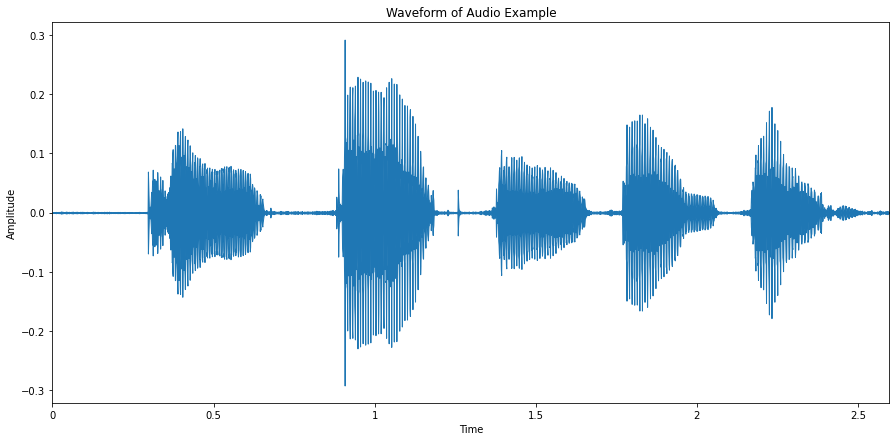

In [4]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

/home/tibor/venv/rgsttmix/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/tibor/venv/rgsttmix/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/tibor/venv/rgsttmix/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


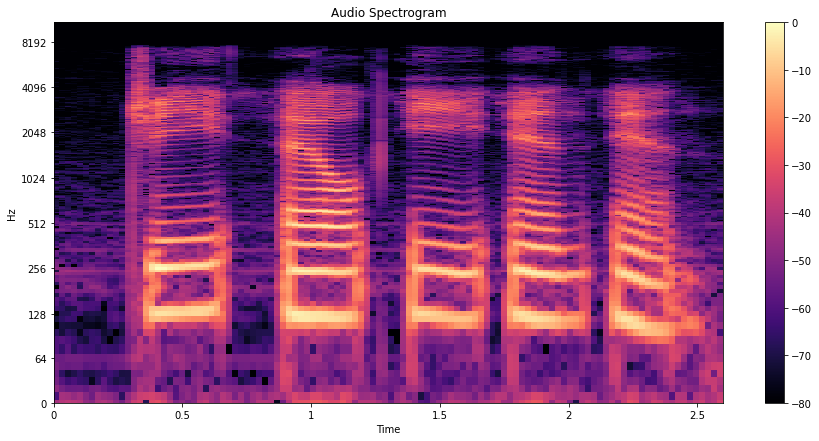

In [5]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

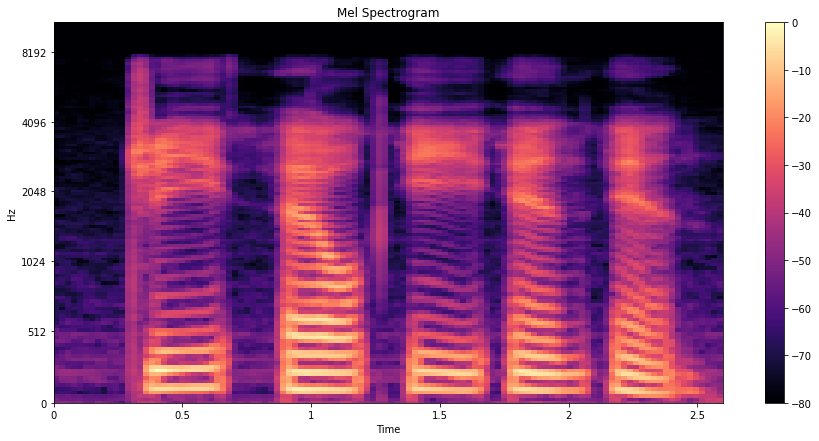

In [6]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Convolutional ASR Models

Let's take a look at the model that we will be building, and how we specify its parameters.

### The Jasper Model

We will be training a small [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288) from scratch (e.g. initialized randomly). 
In brief, Jasper architectures consist of a repeated block structure that utilizes 1D convolutions.
In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times.
We also have a one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss.

### The QuartzNet Model

The QuartzNet is better variant of Jasper with a key difference that it uses time-channel separable 1D convolutions. This allows it to dramatically reduce number of weights while keeping similar accuracy.

A Jasper/QuartzNet models look like this (QuartzNet model is pictured):

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)

# Using NeMo for Automatic Speech Recognition

Now that we have an idea of what ASR is and how the audio data looks like, we can start using NeMo to do some ASR!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/r1.0.0rc1/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. NeMo also comes with complete models which only require your data and hyperparameters for training.

In [7]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[NeMo W 2021-03-10 20:06:25 experimental:27] Module <class 'nemo.collections.asr.models.clustering_diarizer.ClusteringDiarizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-03-10 20:06:25 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali.AudioToCharDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-03-10 20:06:25 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" bac

## Using an Out-of-the-Box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet15x5 model.

In [8]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2021-03-10 20:06:25 cloud:56] Found existing object /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-03-10 20:06:25 cloud:62] Re-using file from: /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2021-03-10 20:06:25 common:615] Instantiating model from pre-trained checkpoint
[NeMo I 2021-03-10 20:06:26 features:240] PADDING: 16
[NeMo I 2021-03-10 20:06:26 features:256] STFT using torch
[NeMo I 2021-03-10 20:06:29 modelPT:376] Model EncDecCTCModel was successfully restored from /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


Next, we'll simply add paths to files we want to transcribe into the list and pass it to our model. Note that it will work for relatively short (<25 seconds) files. 

In [9]:
files = ['./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav']
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-03-10 20:06:29 patch_utils:49] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-03-10 20:06:29 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
      return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
    


Audio in ./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


That was easy! But there are plenty of scenarios where you would want to fine-tune the model on your own data or even train from scratch. For example, this out-of-the box model will obviously not work for Spanish and would likely perform poorly for telephone audio. So if you have collected your own data, you certainly should attempt to fine-tune or train on it!

## Training from Scratch

To train from scratch, you need to prepare your training data in the right format and specify your models architecture.

### Creating Data Manifests

The first thing we need to do now is to create manifests for our training and evaluation data, which will contain the metadata of our audio files. NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`, which have lines containing transcripts and their corresponding audio file IDs:
```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...
```

In [10]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("***Done***")

******
Training manifest created.
Test manifest created.
***Done***


### Specifying Our Model with a YAML Config File

For this tutorial, we'll build a *Jasper_4x1 model*, with `K=4` blocks of single (`R=1`) sub-blocks and a *greedy CTC decoder*, using the configuration found in `./configs/config.yaml`.

If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled `encoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```
The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`.
Next, we have four entries that correspond to the `K=4` blocks, and each has `repeat: 1` since we are using `R=1`.
These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify how we will handle training (`train_ds`) and validation (`validation_ds`) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

In [11]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter'}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False}, 'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'normal

### Training with PyTorch Lightning

NeMo models and modules can be used in any PyTorch code where torch.nn.Module is expected.

However, NeMo's models are based on [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs

In [12]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=50)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Next, we instantiate and ASR model based on our ``config.yaml`` file from the previous section.
Note that this is a stage during which we also tell the model where our training and validation manifests are.

In [13]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2021-03-10 20:07:23 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-03-10 20:07:23 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-03-10 20:07:23 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-03-10 20:07:23 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-03-10 20:07:23 features:240] PADDING: 16
[NeMo I 2021-03-10 20:07:23 features:256] STFT using torch


With that, we can start training with just one line!

In [14]:
# Start training!!!
trainer.fit(first_asr_model)

[NeMo I 2021-03-10 20:07:24 modelPT:685] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2021-03-10 20:07:24 lr_scheduler:617] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f80704b4970>" 
    will be used during training (effective maximum steps = 1500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1500
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
[NeMo W 2021-03-10 20:07:25 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argu

Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-03-10 20:07:25 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
      warnings.warn(*args, **kwargs)
    
[NeMo W 2021-03-10 20:07:25 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      warnings.warn(*args, **kwargs)
    


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

There we go! We've put together a full training pipeline for the model and trained it for 50 epochs.

If you'd like to save this model checkpoint for loading later (e.g. for fine-tuning, or for continuing training), you can simply call `first_asr_model.save_to(<checkpoint_path>)`. Then, to restore your weights, you can rebuild the model using the config (let's say you call it `first_asr_model_continued` this time) and call `first_asr_model_continued.restore_from(<checkpoint_path>)`.

### After Training: Monitoring Progress and Changing Hyperparameters
We can  now start Tensorboard to see how training went. Recall that WER stands for Word Error Rate and so the lower it is, the better.

In [15]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir lightning_logs/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

To use tensorboard, please use this notebook in a Google Colab environment.


We could improve this model by playing with hyperparameters. We can look at the current hyperparameters with the following:

In [16]:
print(params['model']['optim'])

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


Let's say we wanted to change the learning rate. To do so, we can create a `new_opt` dict and set our desired learning rate, then call `<model>.setup_optimization()` with the new optimization parameters.

In [17]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))
# And then you can invoke trainer.fit(first_asr_model)

[NeMo I 2021-03-10 20:10:53 modelPT:685] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-03-10 20:10:53 lr_scheduler:617] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f8070114220>" 
    will be used during training (effective maximum steps = 1500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1500
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7f8070114220>,
  'interval': 'step',
  'frequency': 1,
  'monitor': 'val_loss',
  'reduce_on_plateau': False})

## Inference

Let's have a quick look at how one could run inference with NeMo's ASR model.

First, ``EncDecCTCModel`` and its subclasses contain a handy ``transcribe`` method which can be used to simply obtain audio files' transcriptions. It also has batch_size argument to improve performance.

In [18]:
print(first_asr_model.transcribe(paths2audio_files=['./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav',
                                                    './an4/wav/an4_clstk/fmjd/cen7-fmjd-b.wav',
                                                    './an4/wav/an4_clstk/fmjd/cen8-fmjd-b.wav',
                                                    './an4/wav/an4_clstk/fkai/cen8-fkai-b.wav'],
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['g l e n n', 'four two on o one nine six', ' seven fourte sixty one', 'oter fhir nineten sixy nine']


Below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [19]:
# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo I 2021-03-10 20:10:58 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-03-10 20:10:58 collections:174] 0 files were filtered totalling 0.00 hours
WER = 0.553686934023286


This WER is not particularly impressive and could be significantly improved. You could train longer (try 100 epochs) to get a better number. Check out the next section on how to improve it further.

## Model Improvements

You already have all you need to create your own ASR model in NeMo, but there are a few more tricks that you can employ if you so desire. In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

Our toy model does not do spectrogram augmentation. But the real one we got from cloud does:

In [20]:
print(quartznet._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


If you want to enable SpecAugment in your model, make sure your .yaml config file contains 'model/spec_augment' section which looks like the one above.

### Transfer learning

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a task with abundant training data and then fine-tuned on different tasks of interest where the training data is less abundant or even scarce.

In ASR you might want to do fine-tuning in multiple scenarios, for example, when you want to improve your model's performance on a particular domain (medical, financial, etc.) or on accented speech. You can even transfer learn from one language to another! Check out [this paper](https://arxiv.org/abs/2005.04290) for examples.

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on AN4 data. (NOTE: this is a toy example). And, while we are at it, we will change model's vocabulary, just to demonstrate how it's done.

In [21]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    ]
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2021-03-10 20:11:03 ctc_models:255] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!'] vocabulary.


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune-this model for 2 epochs on AN4 dataset. We will also use the smaller learning rate from ``new_opt` (see the "After Training" section)`.

In [23]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(quartznet)

[NeMo I 2021-03-10 20:11:30 modelPT:685] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-03-10 20:11:30 lr_scheduler:600] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2021-03-10 20:11:30 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-03-10 20:11:30 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-03-10 20:11:30 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-03-10 20:11:30 collections:174] 0 files were filtered totalling 0.00 hours


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-03-10 20:11:30 modelPT:685] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-03-10 20:11:30 lr_scheduler:600] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 30.8 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can use [PyTorch Lightning's Trainer object](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=Trainer) to handle mixed-precision and distributed training for you. Below are some examples of flags you would pass to the `Trainer` to use these features:

```python
# Mixed precision:
trainer = pl.Trainer(amp_level='O1', precision=16)

# Trainer with a distributed backend:
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp')

# Of course, you can combine these flags as well.
```

Finally, have a look at [example scripts in NeMo repository](https://github.com/NVIDIA/NeMo/blob/main/examples/asr/speech_to_text.py) which can handle mixed precision and distributed training using command-line arguments.

### Deployment

Let's get back to our pre-trained model and see how easy it can be exported to an ONNX file
in order to run it in an inference engine like TensorRT or ONNXRuntime.
If you don't have one, let's install it:

In [24]:
!mkdir -p ort
%cd ort
!git clean -xfd
!git clone --depth 1 --branch v1.5.2 https://github.com/microsoft/onnxruntime.git .
!./build.sh --skip_tests --config Release --build_shared_lib --parallel --use_cuda --cuda_home /usr/local/cuda --cudnn_home /usr/lib/x86_64-linux-gnu --build_wheel
!pip uninstall -y onnxruntime
!pip uninstall -y onnxruntime-gpu
!pip install  --upgrade --force-reinstall ./build/Linux/Release/dist/onnxruntime*.whl
%cd ..

/home/tibor/asr/NeMo/tutorials/asr/ort
Cloning into '.'...
remote: Enumerating objects: 4420, done.
remote: Counting objects: 100% (4420/4420), done.
remote: Compressing objects: 100% (3950/3950), done.
remote: Total 4420 (delta 816), reused 1764 (delta 360), pack-reused 0
Receiving objects: 100% (4420/4420), 259.88 MiB | 4.34 MiB/s, done.
Resolving deltas: 100% (816/816), done.
Note: switching to 'ad7cc541ff96f32cc6dd27040f27a451b36acdef'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (3952/3952), done

Then run

In [ ]:
import json
import os
import tempfile
import onnxruntime
import torch

import numpy as np
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.data.audio_to_text import AudioToCharDataset
from nemo.collections.asr.metrics.wer import WER

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def setup_transcribe_dataloader(cfg, vocabulary):
    config = {
        'manifest_filepath': os.path.join(cfg['temp_dir'], 'manifest.json'),
        'sample_rate': 16000,
        'labels': vocabulary,
        'batch_size': min(cfg['batch_size'], len(cfg['paths2audio_files'])),
        'trim_silence': True,
        'shuffle': False,
    }
    dataset = AudioToCharDataset(
        manifest_filepath=config['manifest_filepath'],
        labels=config['labels'],
        sample_rate=config['sample_rate'],
        int_values=config.get('int_values', False),
        augmentor=None,
        max_duration=config.get('max_duration', None),
        min_duration=config.get('min_duration', None),
        max_utts=config.get('max_utts', 0),
        blank_index=config.get('blank_index', -1),
        unk_index=config.get('unk_index', -1),
        normalize=config.get('normalize_transcripts', False),
        trim=config.get('trim_silence', True),
        load_audio=config.get('load_audio', True),
        parser=config.get('parser', 'en'),
        add_misc=config.get('add_misc', False),
    )
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=config['batch_size'],
        collate_fn=dataset.collate_fn,
        drop_last=config.get('drop_last', False),
        shuffle=False,
        num_workers=config.get('num_workers', 0),
        pin_memory=config.get('pin_memory', False),
    )

quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

quartznet.export('qn.onnx')

ort_session = onnxruntime.InferenceSession('qn.onnx')

with tempfile.TemporaryDirectory() as tmpdir:
    with open(os.path.join(tmpdir, 'manifest.json'), 'w') as fp:
        for audio_file in files:
            entry = {'audio_filepath': audio_file, 'duration': 100000, 'text': 'nothing'}
            fp.write(json.dumps(entry) + '\n')

    config = {'paths2audio_files': files, 'batch_size': 4, 'temp_dir': tmpdir}
    temporary_datalayer = setup_transcribe_dataloader(config, quartznet.decoder.vocabulary)
    for test_batch in temporary_datalayer:
        processed_signal, processed_signal_len = quartznet.preprocessor(
            input_signal=test_batch[0].to(quartznet.device), length=test_batch[1].to(quartznet.device)
        )
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(processed_signal),}
        ologits = ort_session.run(None, ort_inputs)
        alogits = np.asarray(ologits)
        logits = torch.from_numpy(alogits[0])
        greedy_predictions = logits.argmax(dim=-1, keepdim=False)
        wer = WER(vocabulary=quartznet.decoder.vocabulary, batch_dim_index=0, use_cer=False, ctc_decode=True)
        hypotheses = wer.ctc_decoder_predictions_tensor(greedy_predictions)
        print(hypotheses)
        break


[NeMo I 2021-03-10 20:46:42 cloud:56] Found existing object /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-03-10 20:46:42 cloud:62] Re-using file from: /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2021-03-10 20:46:42 common:615] Instantiating model from pre-trained checkpoint
[NeMo I 2021-03-10 20:46:43 features:240] PADDING: 16
[NeMo I 2021-03-10 20:46:43 features:256] STFT using torch
[NeMo I 2021-03-10 20:46:43 modelPT:376] Model EncDecCTCModel was successfully restored from /home/tibor/.cache/torch/NeMo/NeMo_1.0.0rc1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


[NeMo W 2021-03-10 20:46:43 conv_asr:61] Turned off 170 masked convolutions
[NeMo W 2021-03-10 20:46:43 export_utils:198] Swapped 0 modules
[NeMo W 2021-03-10 20:46:44 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/torch/onnx/utils.py:1111: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input audio_signal
      warnings.warn('No names were found for specified dynamic axes of provided input.'
    
[NeMo W 2021-03-10 20:46:44 nemo_logging:349] /home/tibor/venv/rgsttmix/lib/python3.8/site-packages/torch/onnx/utils.py:1111: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input logprobs
      warnings.warn('No names were found for specified dynamic axes of provided input.'
    


[NeMo I 2021-03-10 20:46:51 exportable:231] onnx-graphsurgeon module is not instlled.That may result in suboptimal optimization of exported ONNX graph (including unneeded DOUBLE initializers).Please follow the instructions available at:https://github.com/NVIDIA/TensorRT/tree/master/tools/onnx-graphsurgeonto install onnx-graphsurgeon from source to improve exported graph.
[NeMo I 2021-03-10 20:46:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2021-03-10 20:46:53 collections:174] 0 files were filtered totalling 0.00 hours


## Under the Hood

NeMo is open-source and we do all our model development in the open, so you can inspect our code if you wish.

In particular, ``nemo_asr.model.EncDecCTCModel`` is an encoder-decoder model which is constructed using several ``Neural Modules`` taken from ``nemo_asr.modules.`` Here is what its forward pass looks like:
```python
def forward(self, input_signal, input_signal_length):
    processed_signal, processed_signal_len = self.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )
    # Spec augment is not applied during evaluation/testing
    if self.spec_augmentation is not None and self.training:
        processed_signal = self.spec_augmentation(input_spec=processed_signal)
    encoded, encoded_len = self.encoder(audio_signal=processed_signal, length=processed_signal_len)
    log_probs = self.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    return log_probs, encoded_len, greedy_predictions
```
Here:

* ``self.preprocessor`` is an instance of ``nemo_asr.modules.AudioToMelSpectrogramPreprocessor``, which is a neural module that takes audio signal and converts it into a Mel-Spectrogram
* ``self.spec_augmentation`` - is a neural module of type ```nemo_asr.modules.SpectrogramAugmentation``, which implements data augmentation. 
* ``self.encoder`` - is a convolutional Jasper/QuartzNet-like encoder of type ``nemo_asr.modules.ConvASREncoder``
* ``self.decoder`` - is a ``nemo_asr.modules.ConvASRDecoder`` which simply projects into the target alphabet (vocabulary).

Also, ``EncDecCTCModel`` uses the audio dataset class ``nemo_asr.data.AudioToCharDataset`` and CTC loss implemented in ``nemo_asr.losses.CTCLoss``.

You can use these and other neural modules (or create new ones yourself!) to construct new ASR models.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)